# Pretraining on unlabeled data

This chapter covers training our model as well as using basic model evaluation techniques.

In [9]:
# Setting the previous LLM
import torch
from chapter04 import GPTModel

GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, # Reduced context length to just 256 tokens
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12,
 "drop_rate": 0.1,
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [10]:
# Functions for text to code
import tiktoken
from chapter04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
 """Converts texts to token ids"""
 encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
 # Converts TokenIds into a Pytorch tensor
 encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
 return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
 "Changes ids to text"
 flat = token_ids.squeeze(0)
 return tokenizer.decode(flat.tolist()) # Converts back into text

# Sample text
start_context = "Every effort moves you"
# Initializes tokenizer
tokenizer = tiktoken.get_encoding("gpt2")
# Obtains the Token IDs
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(start_context, tokenizer),
 max_new_tokens=10,
 context_size=GPT_CONFIG_124M["context_length"]
)
# Final generated text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


As the generated text does not make any sense we have to train it, but first we will create a loss function to evaluate our model.

**Text generation loss**

In [11]:
import torch
# Starting with a brief example
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
 [40, 1107, 588]]) # "I really like"]

# Targets are inputs shifted one position forward
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
 [1107, 588, 11311]]) # " really like chocolate"]

# Porviding the input to our model
with torch.no_grad(): # No training yet
 logits = model(inputs) # Output

probas = torch.softmax(logits, dim=-1) # Softmax
print(probas.shape)
# First number is the batch -> 2 (two example in the input)
# Second number is the number of tokens -> 3 (tokens in each input )
# Last number is the embedding dimensionality

# Obtaining best values
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
# Outputs one value per input token
print("Token IDs:\n", token_ids)

# Decoding the tokens
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


# Obtaining the respective probabilities
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

# We want to maximize the likelihood of the correct word appearing, which in other terms also means having a higher 
# probability with respect to other words

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


General structure for computing the loss


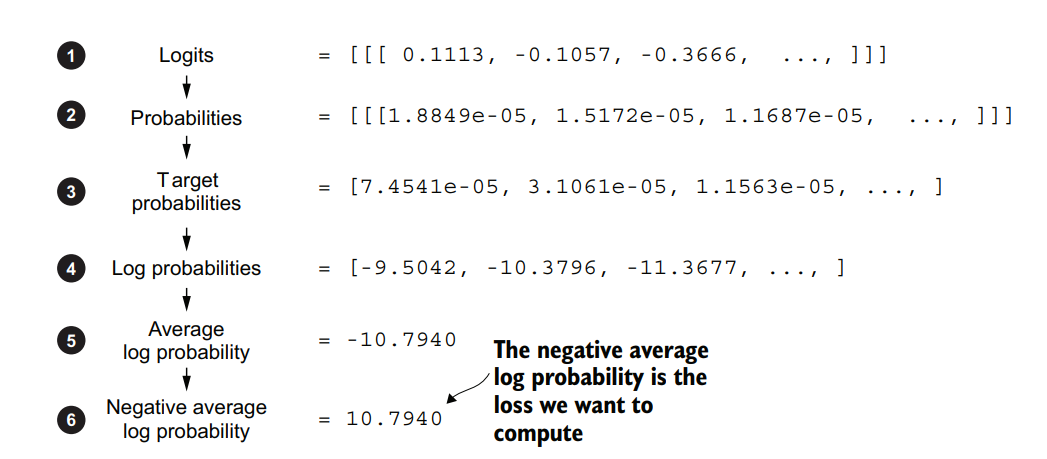

Logarithms are used due to their differentiability, they also dont make small numbers not vanish, as well as changing multiplications to sums

In [12]:
# We will proceed computing the logs
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("Log probabilities: ",log_probas)

# Obtainin the mean
avg_log_probas = torch.mean(log_probas)
print("Mean: ", avg_log_probas) # We want this number to be close to 0

# Negative average, for optimization as most optimizers find minimums
neg_avg_log_probas = avg_log_probas * -1 # Also known as cross entropy

Log probabilities:  tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
Mean:  tensor(-10.7940)


In [13]:
# Applying cross entropy 
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

# We need to flatten them for the function
logits_flat = logits.flatten(0, 1) # Unscaled output
targets_flat = targets.flatten() # Toekns we want the model to generate
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

# Cross-entropy function
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Loss: ",loss)

# Perplexity
# Compares the predicted probability distribution to see if it matches the actual distribution of the words in the dataset.
# In this case, it defines the amount of elements in the vocabulary the model is unsure to generate next
perplexity = torch.exp(loss)
print("Perplexity: ", perplexity) # Unsure about 48725 words

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Loss:  tensor(10.7940)
Perplexity:  tensor(48725.8203)


**Calculating training and validation losses**

In [14]:
# Using the Verdict txt file
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
 text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)
# Simple text just to have a good view of what we are dealing with

Characters: 20479
Tokens: 5145


In [15]:
# Splitting into testing and training
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# Using our previously created dataloaders
from chapter02 import create_dataloader_v1
torch.manual_seed(123)


train_loader = create_dataloader_v1(
 train_data,
 batch_size=2, # Small batch size due to how short our text is
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)

val_loader = create_dataloader_v1(
 val_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)

print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

# 9 training set batches 

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


**Loss functions**

In [16]:
# Cross entropy loss of a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
 """ Input batch: batch of input data
 target batch: labels we wish to predict
 model: NN model
 device: CPU or GPU"""
 
 # Used more commonly for GPU
 input_batch = input_batch.to(device)
 target_batch = target_batch.to(device)

 # Output
 logits = model(input_batch)

 # Loss
 loss = torch.nn.functional.cross_entropy(
 logits.flatten(0, 1), target_batch.flatten()
 )
 return loss

# Loss over all batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
 """ data_loader: DataLoader for providing batches of input
 model: evaluated model
 device: CPU or GPU
 num_batches: batches used to compute loss, if None, all batches are used"""
 
 # Initalize loss
 total_loss = 0.

 # Empty data
 if len(data_loader) == 0:
    return float("nan")
 
 # Define batches used
 elif num_batches is None:
    num_batches = len(data_loader)
 else:
    num_batches = min(num_batches, len(data_loader))
    # Loop over data, for each batch
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch( # COmputes loss
            input_batch, target_batch, model, device
            )
            total_loss += loss.item() # Adds the loss
        else:
            break

 # Returns average loss
 return total_loss / num_batches 

In [21]:
import torch
# Testing our code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU if available
model.to(device)

model.eval()
# No training yet
with torch.no_grad():
 train_loss = calc_loss_loader(train_loader, model, device)
 val_loss = calc_loss_loader(val_loader, model, device)
 
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 0.0
Validation loss: 0.0
